# I. Predicting Massachusetts Precipitation

Here, I'll analyze Massachusetts precipitation data to understand changing weather and climate patterns and predict what this winter's wet weather will look like.

## Motivation

Since moving to the Boston area in 2018, I feel like I have watched the weather change and the climate shift. It's hotter and I have to water my plants more often. It seems like there are fewer thunderstorms in the summer and a bit less snow on the ground every year. As weather conditions in the Northeast became hotter and drier in the summer of 2022 (), many Bay Staters will have become more familiar with red and orange maps showing the statewide drought risk. The consequences are commonsense: indoor and outdoor water usage increases as reservoir and groundwater levels drop, vegetation dries out, and fire risks increase. 
 
<img src="Supporting_images\ma_drought_map_09-08-22.jpg" title ="A map of drought conditions across Massachusetts during August 2022. Source: <https://www.mass.gov/doc/august-24-2022/download>" width="400"/> 

The drought maps remind me of the permanent fire risk signage I grew up with in the Pacific Northwest, whose heavy arrows always seemed permanently weighted towards that red area - Extreme Risk. Every fire season had its regular calling cards: the road signs, their silent warnings, and the dried grass at their bases. We would start looking earlier though, aiming our eyes at the Cascade Mountains and waiting for the snow to fall. To melt. 

<img src="Supporting_images\Crooked_River_Ranch_firesign.jpg" title ="A fire danger sign in Jefferson County, Oregon showing extreme fire danger. Source: <https://www.crrfire.org/fire-danger-increases-to-extreme-campfires-closed>" width="400"/>

Now, global climate change is driving shifts in where and how much precipitation falls. While floods submerge Pakistan, droughts imperil American agriculture (). It feels like we are waiting again, many of us asking, "How will these changing climate patterns affect us? Our homes?" This question might seem dramatic, but its pragmatic cousin is asked more frequently: "What's the weather forecast?" 

A forecast is a model that is based on the prior results that helps us anticipate and plan for future conditions. Weather- the atmospheric conditions at a specific time and place- can be measured and analyzed to produce models of the climate- atmpsheric patterns across broader regions and timespans. These models, based on the past, can be used to predict future conditions. However, if the weather conditions being predicted have changed from the conditions used to build the model, the climate model will not be able to accurately predict the weather.

As an earth scientist, I'm deeply curious about how terrestrial conditions like climate impact organisms' abilities to navigate thier environment. As a Bostonian, I  want to know if I can expect a wet winter in 2022 (and the postive knock-on effects in 2023). My goal in this analysis is limited to:

- cleaning the data and structuring it in multiple tables
- calculating and analyzing exploratory metrics to quantify data completeness and range, etc.
- applying supervised machine learning models (linear regression, random forest, and XGBoost) to one station's record
- evaluating model performance and recommending a specific method
- predicting the monthly precipitation at that station for January to July 2023 using 

In [2]:
# Import packages
import copy
import math
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


In [3]:
# Import prepared datasets
precip_flat = pd.read_csv(r'C:\Users\15414\Documents\GitHub\MA Precip\MAPrecipData\Products\precip_flat.csv')
precip_multi = pd.read_csv(r'C:\Users\15414\Documents\GitHub\MA Precip\MAPrecipData\Products\precip_multi.csv')
unique_stations = pd.read_csv(r'C:\Users\15414\Documents\GitHub\MA Precip\MAPrecipData\Products\unique_stations.csv')
unique_basins = pd.read_csv(r'C:\Users\15414\Documents\GitHub\MA Precip\MAPrecipData\Products\unique_basins.csv')
unique_stations.head(2)


,Region,Basin Name,CITY,STATION,First_year_collected,Last_year_collected,Months_sampled,Months_not_reported,Percent_months_reported
0,Connecticut River,CONNECTICUT,Amherst,AMH307,1997,2019,264,44,0.833333
1,Connecticut River,CONNECTICUT,Amherst,AMHNWS,1838,2015,2136,0,1.000000


# Exploratory Analyses

## Temporal Patterns

First, I want to answer some basic questions about the dataset's range and completeness, like:
1. What is the earliest year data was collected and where? 
2. When is the latest year data was collected and how many stations were operating then?
3. What years are reported for each station? Are patterns or significant dates present? 
4. How complete is each station's record (e.g., how many months were reported as NaN)? 

In [89]:
# Calculate answers to question 1.
n_total_stations = len(unique_stations)

earliest_year = precip_flat['Year'].min()

earliest_station_data = precip_flat.loc[(precip_flat['Year'] == earliest_year) & (precip_flat['Month'] == 1)] # Select first month of 1838 to get row with station name.
earliest_station = earliest_station_data['Station'].iloc[0] # Isolate station name.

print(f'What is the earliest year data was collected and where?')
print(f'The first station to collect data was {earliest_station} in {earliest_year}.') 
      

What is the earliest year data was collected and where?
The first station to collect data was AMHNWS in 1838.


In [94]:
# Calculate answer to question 2.

latest_year = precip_flat['Year'].max()

active_stations = precip_flat.loc[(precip_flat['Year'] == latest_year) & (precip_flat['Month'] == 1)] 
n_active_stations = len(active_stations)
percent_stations_active = round(n_active_stations / n_total_stations, 2)

print('When is the latest year data was collected and how many stations were operating then?')
print(f'The latest year data was reported is {latest_year} across {n_active_stations} of {n_total_stations} total stations ({percent_stations_active}%).')


When is the latest year data was collected and how many stations were operating then?
The latest year data was reported is 2019 across 52 of 179 total stations (0.29%).


I expected the last year of data reporting to be 2019 since that is when the dataset was published; it's good to see there are no values exceeding that. This dataset has a total range of 181 years with nearly a third of contributing stations reporting data at the time of dataset publication. 

Plotting the ranges of years stations reported data reveals several cut-off dates where datasets cease to be reported. The most recent, 2019, coincides with year this dataset was published online. In 2015, the year the most stations stopped reporting data, 


Visually, it appears that stations with greater record lengths have increased record completeness; this seems reasonable given that many data collection and reporting processes improve over time. While a linear regression shows a significant relationship between  record length and completeness (p < 0.05), the extremely low R^2 value indicates station age does not contribute to much variation in record completeness.


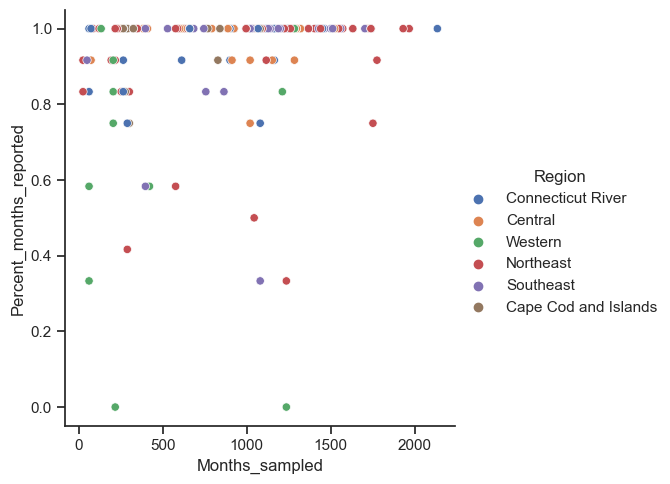

In [95]:
sns.relplot(
    data = unique_stations,
    x='Months_sampled', y='Percent_months_reported',
    hue='Region',
)

In [ ]:
sample_vs_report_reg = stats.linregress(unique_stations['Months_sampled'], unique_stations['Percent_months_reported'])
r2 = round(sample_vs_report_reg.rvalue*sample_vs_report_reg.rvalue, 3)
p = round(sample_vs_report_reg.pvalue, 3)

print(f"Months_sampled vs. Percent_months_reported \nLinear Regression: \nr^2: {r2}. \np  : {p}.")


There seem two be two clumps of low-coverage data: those at y = 0.0 and 0.35 < y < 0.6. Extracting those records shows 11 stations with less than 60% coverage and two stations reporting no coverage at all. 

In [ ]:
unique_stations[unique_stations['Percent_months_reported'] < 0.6 ] 


Within a single station, there are multiple cycles present: the yearly component but also  

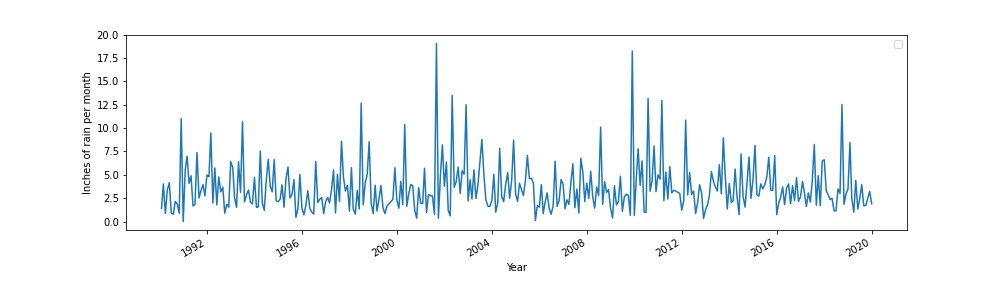

# Acknowlegments

This work would not be possible without data provided by the Massachussets State Department of Conservation and Recreation, Drought Management Task Force, and  Executive Office of Energy and Environemntal Affairs. The data itself was collected by the MA Department of Conservation and Recreation, the National Weather Service, the US Army Corps of Engineers, and the United States Geological Survey. I would like to thank...

I have no conflicts of interest to disclose.


# Notes

### Data to follow up on
https://www.mass.gov/doc/framework-november-2012/download